## 0 - Import Modules and Data

In [113]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV


import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from scipy.stats import zscore

from imblearn.over_sampling import SMOTE

import os
import joblib


# Plotting style
ftsize_title = 20
ftsize_axis = 16
sns.set_style('whitegrid')
sns.set_palette("viridis")

In [225]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


# Step 1: Load original training and test data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

# # Step 2: Load extra data
# df_extra = pd.read_csv("data/extra.csv")

# # Step 3: Split extra data into features and target
# X_extra = df_extra.drop('TARGET', axis=1)
# y_extra = df_extra['TARGET']

# # Step 4: Concatenate original and extra data
# X = pd.concat([X, X_extra], ignore_index=True)
# y = pd.concat([y, y_extra], ignore_index=True)

# # Step 5: Confirm result
# print(f"Combined X shape: {X.shape}")
# print(f"Combined y shape: {y.shape}")
# print(y.value_counts())

## 1 - Filter dataset

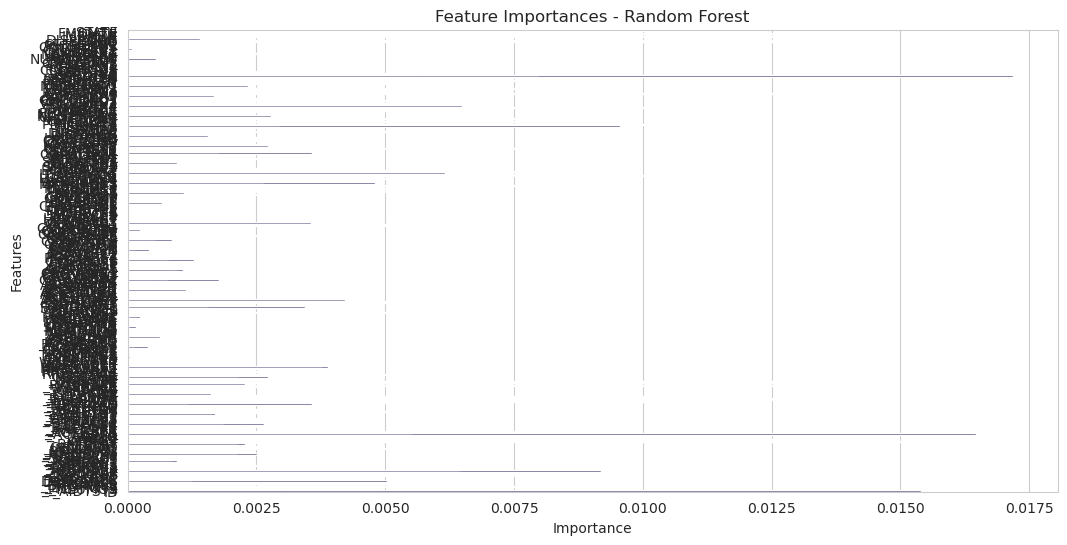

In [207]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [228]:
# remove all features with importance less than 0.005
important_features = feature_names[importances > 0.01]
print(important_features)
X_important = X[important_features]

# apply same changes to test set
X_test = df_test[important_features]

print(X_important.shape)

X_important.info()

Index(['_STATE', 'IDATE', 'IDAY', 'SEQNO', '_PSU', 'GENHLTH', 'CVDSTRK3',
       'DIABAGE4', 'WEIGHT2', 'LCSSCNCR', '_STSTR', '_STRWT', '_WT2RAKE',
       '_DUALCOR', '_LLCPWT2', '_LLCPWT', '_RFHLTH', '_AGE80', 'HTIN4', 'HTM4',
       'WTKG3', '_BMI5', 'ID'],
      dtype='object')
(225000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    225000 non-null  float64
 1   IDATE     225000 non-null  int64  
 2   IDAY      225000 non-null  int64  
 3   SEQNO     225000 non-null  int64  
 4   _PSU      225000 non-null  float64
 5   GENHLTH   224999 non-null  float64
 6   CVDSTRK3  224999 non-null  float64
 7   DIABAGE4  30531 non-null   float64
 8   WEIGHT2   216806 non-null  float64
 9   LCSSCNCR  84380 non-null   float64
 10  _STSTR    225000 non-null  float64
 11  _STRWT    225000 non-null  float64
 12  _WT2RAKE  225000 non-null  fl

In [209]:
# print diabage4 feature importance
print(f"Diabage4 feature importance: {importances[feature_names.get_loc('DIABAGE4')]}")

# Remove diabage4 because too much nan values
X_important = X_important.drop('DIABAGE4', axis=1)
X_important.info()

# appluy same changes to test set
X_test = X_test.drop('DIABAGE4', axis=1)

Diabage4 feature importance: 0.01004077068298073
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370132 entries, 0 to 370131
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    370132 non-null  float64
 1   IDATE     370132 non-null  int64  
 2   IDAY      370132 non-null  int64  
 3   SEQNO     370132 non-null  int64  
 4   _PSU      370132 non-null  float64
 5   GENHLTH   370130 non-null  float64
 6   CVDSTRK3  370131 non-null  float64
 7   WEIGHT2   356990 non-null  float64
 8   LCSSCNCR  137556 non-null  float64
 9   _STSTR    370132 non-null  float64
 10  _STRWT    370132 non-null  float64
 11  _WT2RAKE  370132 non-null  float64
 12  _DUALCOR  131149 non-null  float64
 13  _LLCPWT2  370132 non-null  float64
 14  _LLCPWT   370132 non-null  float64
 15  _RFHLTH   370132 non-null  float64
 16  _AGE80    370132 non-null  float64
 17  HTIN4     343327 non-null  float64
 18  HTM4      346468 non-null  float64


Number of features without outliers: 15
Number of features with at least one outlier: 7
Number of rows without outliers: 349543
Number of rows with at least one outlier: 20589


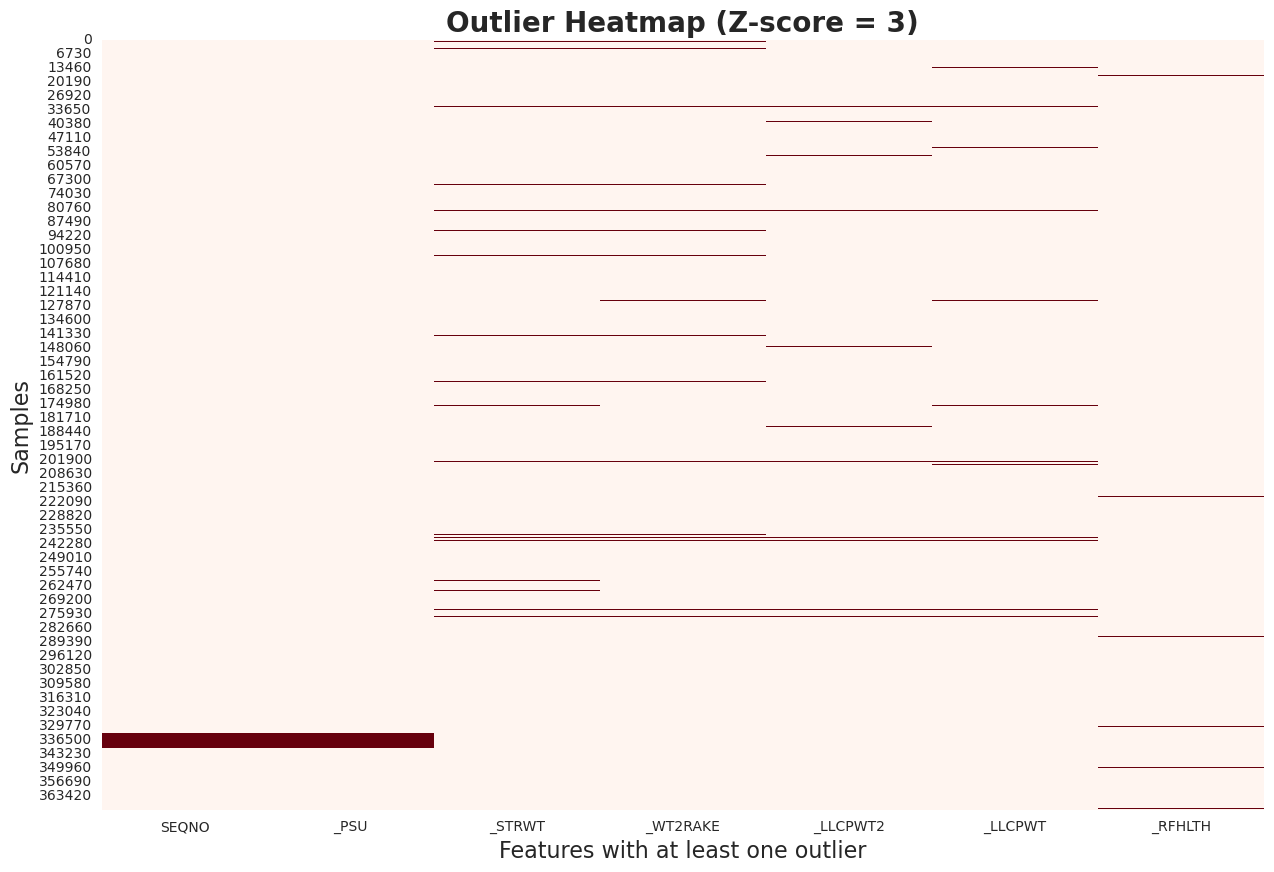

In [210]:
# Calculate Z-scores
z_scores = zscore(X_important)
z_scores_df = pd.DataFrame(z_scores, columns=X_important.columns)

# Define Z-score threshold
threshold = 3
outliers = (np.abs(z_scores_df) > threshold)

# Count the number of features with at least one outlier
nb_features_with_outliers = outliers.any(axis=0).sum()

# Count the number of features without any outliers
nb_features_without_outliers = (~outliers.any(axis=0)).sum()

# Print the results
print(f"Number of features without outliers: {nb_features_without_outliers}")
print(f"Number of features with at least one outlier: {nb_features_with_outliers}")

# Count the number of rows with at least one outlier
nb_rows_with_outliers = outliers.any(axis=1).sum()

# Count the number of rows without any outliers
nb_rows_without_outliers = (~outliers.any(axis=1)).sum()

# Print the results
print(f"Number of rows without outliers: {nb_rows_without_outliers}")
print(f"Number of rows with at least one outlier: {nb_rows_with_outliers}")

# Filter to include only features with at least one outlier
features_with_outliers = z_scores_df.loc[:, outliers.any(axis=0)]

# Plot a heatmap to visualize outliers
plt.figure(figsize=(15,10))
sns.heatmap(np.abs(features_with_outliers) > threshold, cbar=False, cmap='Reds')
plt.title(f'Outlier Heatmap (Z-score = {threshold})', fontsize=ftsize_title, fontweight='bold')
plt.xlabel('Features with at least one outlier', fontsize=ftsize_axis)
plt.ylabel('Samples', fontsize=ftsize_axis)
plt.show()

In [211]:
def class_distribution(y):
    # Plot class distribution
    y_df = pd.DataFrame({'target': y}) 
    
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(
        x='target',
        data=y_df,
        palette='viridis',
        dodge=False,
        order=y_df['target'].value_counts().sort_values().index
    )

    # Title and axis labels
    plt.title('Class Repartition in Heart Risk Dataset', fontsize=ftsize_title, fontweight='bold')
    plt.xlabel('Class', fontsize=ftsize_axis)
    plt.ylabel('Count', fontsize=ftsize_axis)
    plt.xticks(fontsize=ftsize_axis - 4)
    plt.yticks(fontsize=ftsize_axis - 4)

    # Annotate each bar with percentage
    total = len(y_df)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 500,
            percentage,
            ha='center',
            fontsize=ftsize_axis - 4,
            fontweight='bold'
        )

    plt.show()

    # Print class counts
    print(y_df['target'].value_counts())

/tmp/ipykernel_45481/3545263906.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


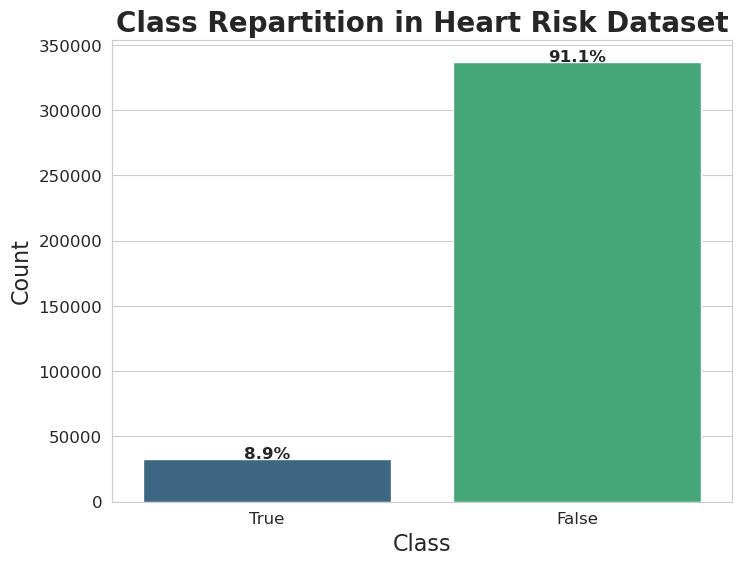

target
False    337115
True      33017
Name: count, dtype: int64


In [212]:
class_distribution(y)

### Remove outliers only for rows where TARGET is False

In [213]:
# Step 1: Split data by TARGET
X_false = X_important[y == False]
X_true = X_important[y == True]

y_false = y[y == False]
y_true = y[y == True]

# Step 2: Compute z-scores and filter outliers only for False rows
z_scores = zscore(X_false)
z_scores_df = pd.DataFrame(z_scores, columns=X_false.columns, index=X_false.index)

threshold = 3  # to tune
outliers = (np.abs(z_scores_df) > threshold)
rows_without_outliers = ~outliers.any(axis=1)

X_false_clean = X_false[rows_without_outliers]
y_false_clean = y_false[rows_without_outliers]

# Step 3: Recombine with untouched True rows
X_without_outliers = pd.concat([X_false_clean, X_true])
y_without_outliers = pd.concat([y_false_clean, y_true])

# Step 4: Inspect results
X_without_outliers.info()
y_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351332 entries, 1 to 370130
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    351332 non-null  float64
 1   IDATE     351332 non-null  int64  
 2   IDAY      351332 non-null  int64  
 3   SEQNO     351332 non-null  int64  
 4   _PSU      351332 non-null  float64
 5   GENHLTH   351332 non-null  float64
 6   CVDSTRK3  351332 non-null  float64
 7   WEIGHT2   338997 non-null  float64
 8   LCSSCNCR  131642 non-null  float64
 9   _STSTR    351332 non-null  float64
 10  _STRWT    351332 non-null  float64
 11  _WT2RAKE  351332 non-null  float64
 12  _DUALCOR  124575 non-null  float64
 13  _LLCPWT2  351332 non-null  float64
 14  _LLCPWT   351332 non-null  float64
 15  _RFHLTH   351332 non-null  float64
 16  _AGE80    351332 non-null  float64
 17  HTIN4     326387 non-null  float64
 18  HTM4      329269 non-null  float64
 19  WTKG3     318549 non-null  float64
 20  _BMI5    

/tmp/ipykernel_45481/3545263906.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


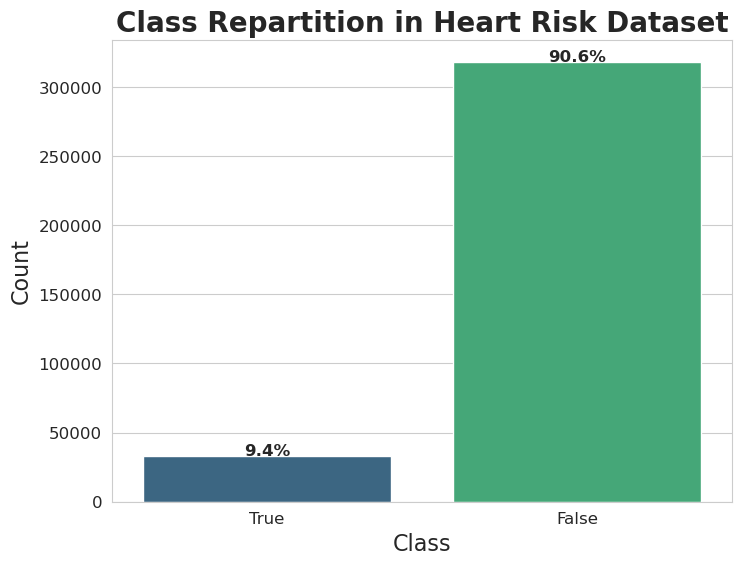

target
False    318315
True      33017
Name: count, dtype: int64


In [214]:
class_distribution(y_without_outliers)

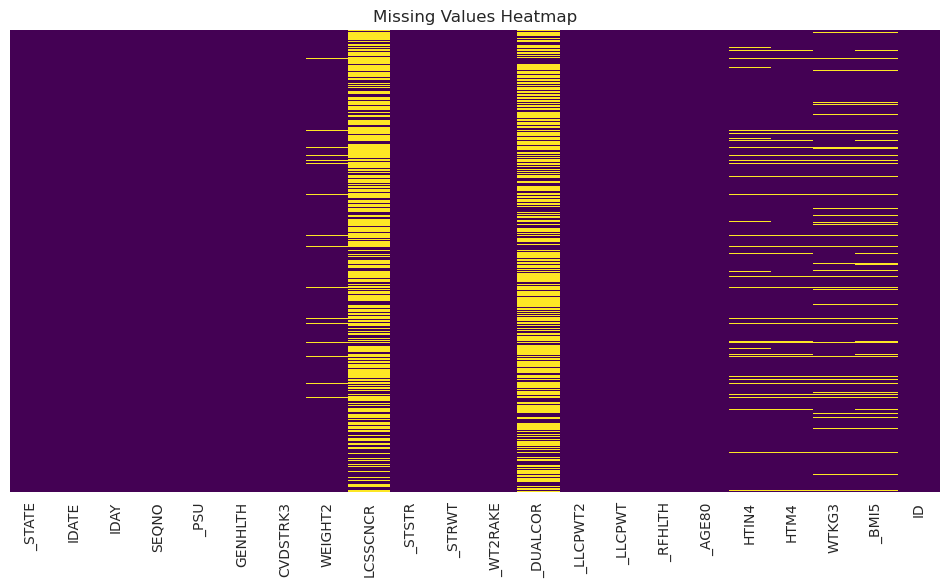

In [215]:
plt.figure(figsize=(12, 6))
sns.heatmap(X_without_outliers.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

### Remove rows with missing values except rows labeled true

In [216]:
# Step 1: Split again by TARGET
X_false = X_without_outliers[y_without_outliers == False]
X_true = X_without_outliers[y_without_outliers == True]

y_false = y_without_outliers[y_without_outliers == False]
y_true = y_without_outliers[y_without_outliers == True]

# Step 2: Drop rows with missing values in False class
X_false_clean = X_false.dropna()
y_false_clean = y_false.loc[X_false_clean.index]  # align y with cleaned X

# Step 3: Recombine with untouched True class
X_without_false_nan = pd.concat([X_false_clean, X_true])
y_without_false_nan = pd.concat([y_false_clean, y_true])

# Step 4: Inspect results
X_without_false_nan.info()
y_without_false_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73889 entries, 2 to 370130
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _STATE    73889 non-null  float64
 1   IDATE     73889 non-null  int64  
 2   IDAY      73889 non-null  int64  
 3   SEQNO     73889 non-null  int64  
 4   _PSU      73889 non-null  float64
 5   GENHLTH   73889 non-null  float64
 6   CVDSTRK3  73889 non-null  float64
 7   WEIGHT2   72971 non-null  float64
 8   LCSSCNCR  63170 non-null  float64
 9   _STSTR    73889 non-null  float64
 10  _STRWT    73889 non-null  float64
 11  _WT2RAKE  73889 non-null  float64
 12  _DUALCOR  56562 non-null  float64
 13  _LLCPWT2  73889 non-null  float64
 14  _LLCPWT   73889 non-null  float64
 15  _RFHLTH   73889 non-null  float64
 16  _AGE80    73889 non-null  float64
 17  HTIN4     72177 non-null  float64
 18  HTM4      72274 non-null  float64
 19  WTKG3     71505 non-null  float64
 20  _BMI5     71178 non-null  float6

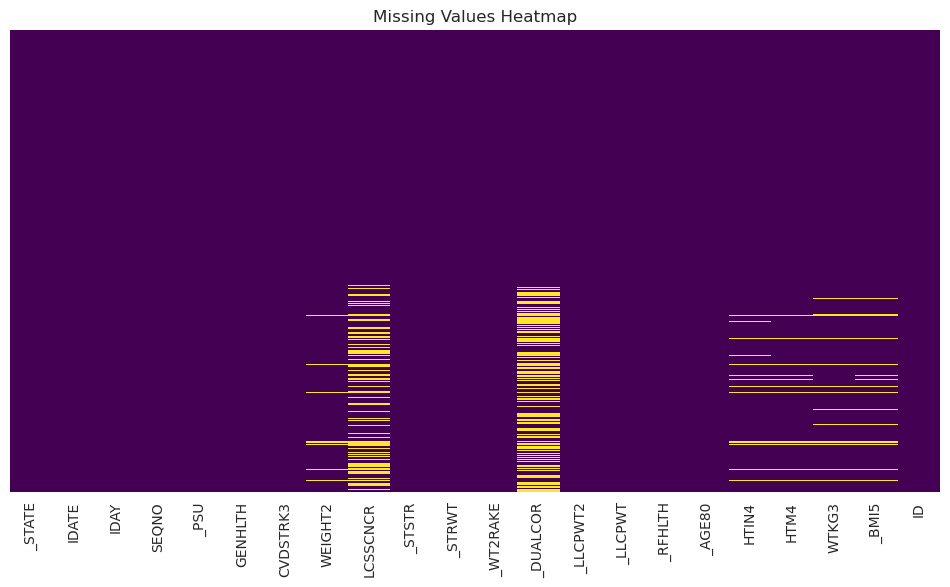

Number of rows after cleaning: 73889
Number of rows that still have missing values: 22730
Number of rows removed due to missing values: 277443
Number of rows removed due to outliers: 18800


In [217]:
plt.figure(figsize=(12, 6))
sns.heatmap(X_without_false_nan.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()
# print number of rows with missing values
print(f"Number of rows after cleaning: {X_without_false_nan.shape[0]}")
print(f"Number of rows that still have missing values: {X_without_false_nan.isnull().any(axis=1).sum()}")
print(f"Number of rows removed due to missing values: {X_without_outliers.shape[0] - X_without_false_nan.shape[0]}")
print(f"Number of rows removed due to outliers: {X_important.shape[0] - X_without_outliers.shape[0]}")

Indicate missing values and impute with median

In [218]:
from sklearn.impute import SimpleImputer

# Step 1: Add missingness indicators
X_with_indicators = X_without_false_nan.copy()
for col in X_with_indicators.columns:
    if X_with_indicators[col].isnull().any():
        X_with_indicators[f'{col}_missing'] = X_with_indicators[col].isnull().astype(int)

# Step 2: Impute missing values (median strategy)
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X_with_indicators)

# Step 3: Reconstruct DataFrame with original index and column names
X_final = pd.DataFrame(X_imputed_array, columns=X_with_indicators.columns, index=X_with_indicators.index)
y_final = y_without_false_nan.copy()

# Step 4: Confirm result
X_final.info()
y_final.info()
print(f"Remaining missing values in X_final: {X_final.isnull().sum().sum()}")
print(f"Remaining missing values in y_final: {y_final.isnull().sum().sum()}")

# do the same for X_test
# Step 1: Add missingness indicators to X_test
X_test_with_indicators = X_test.copy()
for col in X_test.columns:
    if col in X_without_false_nan.columns and X_without_false_nan[col].isnull().any():
        X_test_with_indicators[f'{col}_missing'] = X_test_with_indicators[col].isnull().astype(int)

# Step 2: Align columns with training set (in case some indicators are missing in test)
missing_cols = set(X_with_indicators.columns) - set(X_test_with_indicators.columns)
for col in missing_cols:
    X_test_with_indicators[col] = 0  # fill missing indicator columns with 0

# Step 3: Reorder columns to match training set
X_test_with_indicators = X_test_with_indicators[X_with_indicators.columns]

# Step 4: Apply the same imputer (do NOT fit again)
X_test_imputed_array = imputer.transform(X_test_with_indicators)

# Step 5: Reconstruct DataFrame
X_test_final = pd.DataFrame(X_test_imputed_array, columns=X_with_indicators.columns, index=X_test_with_indicators.index)

# Step 6: Confirm result
X_test_final.info()
print(f"Remaining missing values in X_test_final: {X_test_final.isnull().sum().sum()}")


<class 'pandas.core.frame.DataFrame'>
Index: 73889 entries, 2 to 370130
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _STATE            73889 non-null  float64
 1   IDATE             73889 non-null  float64
 2   IDAY              73889 non-null  float64
 3   SEQNO             73889 non-null  float64
 4   _PSU              73889 non-null  float64
 5   GENHLTH           73889 non-null  float64
 6   CVDSTRK3          73889 non-null  float64
 7   WEIGHT2           73889 non-null  float64
 8   LCSSCNCR          73889 non-null  float64
 9   _STSTR            73889 non-null  float64
 10  _STRWT            73889 non-null  float64
 11  _WT2RAKE          73889 non-null  float64
 12  _DUALCOR          73889 non-null  float64
 13  _LLCPWT2          73889 non-null  float64
 14  _LLCPWT           73889 non-null  float64
 15  _RFHLTH           73889 non-null  float64
 16  _AGE80            73889 non-null  float64
 1

/tmp/ipykernel_45481/3545263906.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


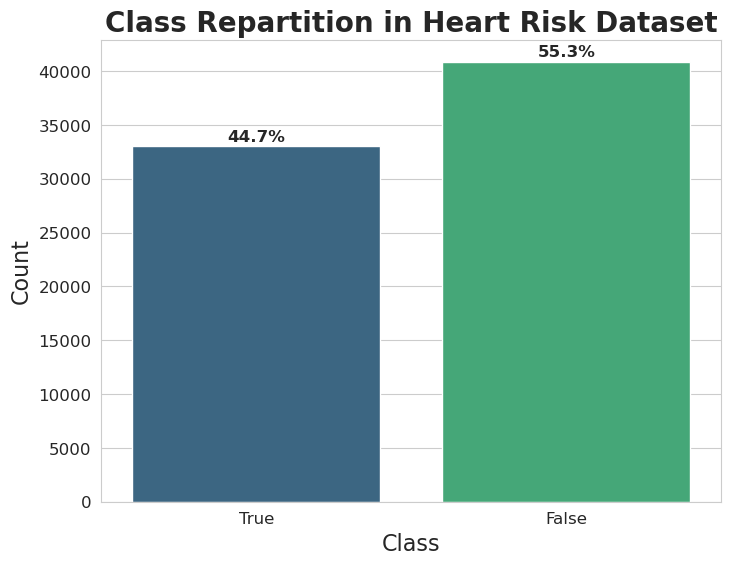

target
False    40872
True     33017
Name: count, dtype: int64


In [219]:
class_distribution(y_final)

In [220]:
# Useful display function
def performance_display(y_test, y_pred, title):
    """Function that displays a beautiful confusion matrix

    Args:
        y_test (pd.DataFrame): True label values of testing set
        y_pred (pd.DataFrame): Predicted label values of testing set
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted', fontsize=ftsize_axis)
    plt.ylabel('Actual', fontsize=ftsize_axis)
    # Invert y axis
    plt.gca().invert_yaxis()
    title = 'Confusion Matrix - ' + title
    plt.title(title, fontsize=ftsize_title, fontweight='bold')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true=y_test, y_pred=y_pred)
    print('Classification Report:')
    print(report)

## Training

In [221]:
def create_submission_file(X_test, filename="submission", model_name="rf.pkl"):
    # Load trained model
    model = joblib.load(f"models/{model_name}")
    print(f"Model loaded from models/{model_name}")

    # Predict TARGET values
    y_pred = model.predict(X_test)

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        "ID": X_test['ID'],
        "TARGET": y_pred.astype(bool)  # Convert to True/False
    })

    # Save to CSV
    filename = f"submissions/{filename}.csv"
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved as {filename}")

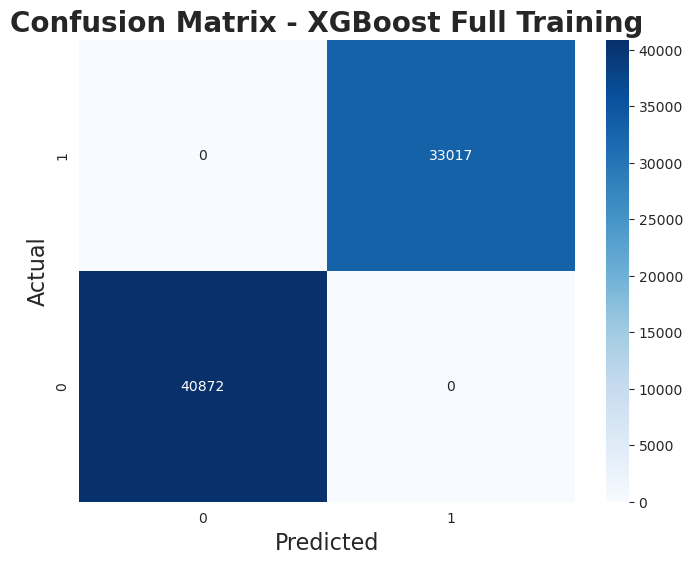

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     40872
        True       1.00      1.00      1.00     33017

    accuracy                           1.00     73889
   macro avg       1.00      1.00      1.00     73889
weighted avg       1.00      1.00      1.00     73889



In [222]:
# train model on full training dataset
xgb = XGBClassifier(n_estimators=500, learning_rate=0.5, max_depth=8, eval_metric='mlogloss', random_state=42)
xgb.fit(X_final, y_final)
joblib.dump(xgb, "models/xgb_V3.pkl")
performance_display(y_final, xgb.predict(X_final), "XGBoost Full Training")

In [224]:
create_submission_file(X_test_final, filename="xgb_V3", model_name="xgb_V3.pkl")

Model loaded from models/xgb_V3.pkl
Submission file saved as submissions/xgb_V3.csv


## 2 - Random Forest

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

########### Training model ###########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed whe

[CV 2/5] END max_depth=None, min_samples_leaf=1, n_estimators=500;, score=0.609 total time= 3.4min
[CV 1/5] END max_depth=None, min_samples_leaf=1, n_estimators=500;, score=0.613 total time= 3.4min
[CV 4/5] END max_depth=None, min_samples_leaf=1, n_estimators=500;, score=0.619 total time= 3.5min
[CV 3/5] END max_depth=None, min_samples_leaf=1, n_estimators=500;, score=0.613 total time= 3.5min
[CV 5/5] END max_depth=None, min_samples_leaf=1, n_estimators=500;, score=0.609 total time= 3.5min


/home/aliho/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


########### Training complete ###########
Model saved to models/rf.pkl

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Best score for Random Forest: 0.6127741920311486


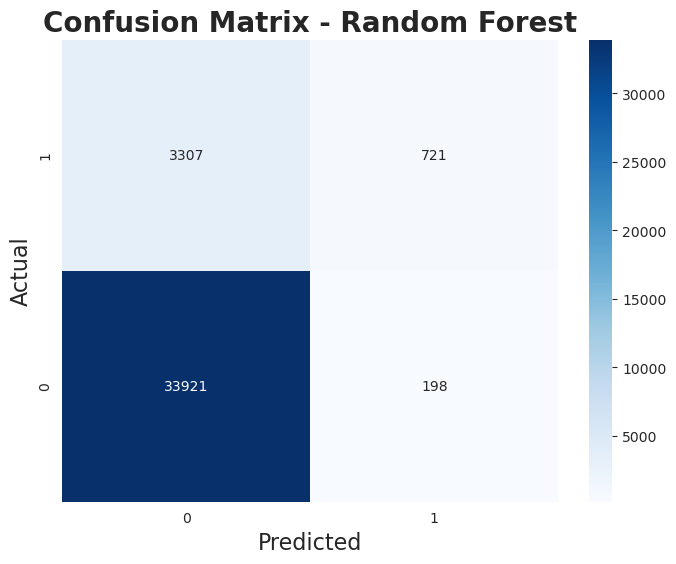

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     34119
        True       0.78      0.18      0.29      4028

    accuracy                           0.91     38147
   macro avg       0.85      0.59      0.62     38147
weighted avg       0.90      0.91      0.88     38147



In [164]:
choice = input("Do you want to train the Random Forest model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter Random Forest model filename to create or load (e.g., rf.pkl): ").strip()

model_path = os.path.join("models", model_name)


if choice == 'train':

    print("########### Training model ###########")

    # Define the parameter grid for Random Forest
    param_grid_rf = {
        # Number of trees in the forest. More trees = better generalization, but slower training.
        'n_estimators': [500],
        # 'n_estimators': [100, 200, 300, 500],  
        # best : 500

        # Maximum depth of each tree. None means nodes are expanded until all leaves are pure. This impacts complexity and overfitting. 
        'max_depth': [None], 
        # 'max_depth': [None, 10, 30], 
        # best : None     
        
        # Minimum number of samples required to be at a leaf node. Higher values reduce overfitting.
        'min_samples_leaf': [1]
        # 'min_samples_leaf': [1, 2, 4] 
        # best : 1
        }

    # Initialize the classifiers
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV for Random Forest
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=3, scoring='f1_macro')

    # Perform grid search for Random Forest
    grid_search_rf.fit(X_train, y_train)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(value=grid_search_rf.best_estimator_, filename=model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

    # Evaluate the best Random Forest model on the validation set
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_val)

    performance_display(y_val, y_pred_rf, "Random Forest")
    

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_rf = model.predict(X_val)
        performance_display(y_val, y_pred_rf, "Loaded Random Forest Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

In [ ]:
# Train on entire dataset
rf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=1, random_state=42)
rf.fit(X_final, y_final)
joblib.dump(value=rf, filename="models/rf.pkl")


Model loaded from models/rf.pkl


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- EMPLOY1_missing
- HTIN4_missing
- HTM4_missing
- WEIGHT2_missing
- WTKG3_missing
- ...


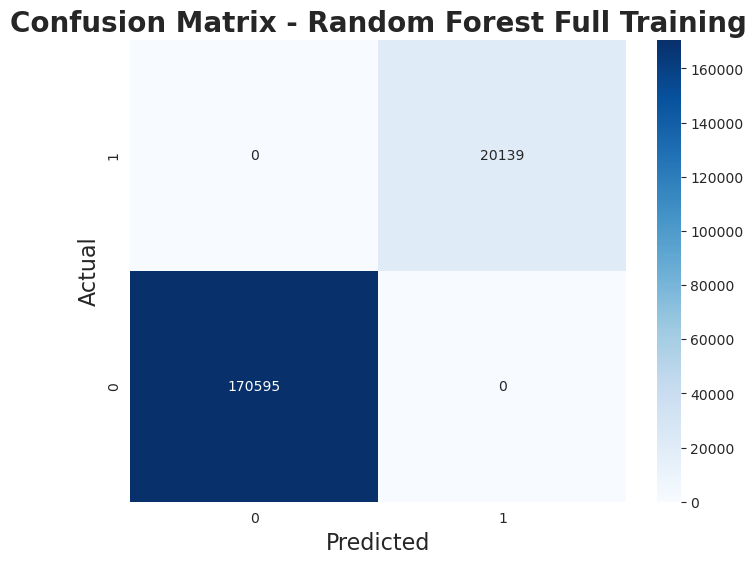

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    170595
        True       1.00      1.00      1.00     20139

    accuracy                           1.00    190734
   macro avg       1.00      1.00      1.00    190734
weighted avg       1.00      1.00      1.00    190734

Model loaded from models/rf.pkl
Submission file saved as submissions/rf_V2_submission.csv


In [189]:
performance_display(y_final, rf.predict(X_final), "Random Forest Full Training")
create_submission_file(X_test_final, filename="rf_V2_submission", model_name="rf.pkl")

## 3 - XGBoost

In [ ]:
# Encode y_train and y_test
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_final)
y_val_encoded = le.transform(y_val)

print(y_train_encoded.shape)
print(y_val_encoded.shape)

(152587,)
(38147,)


########### Training model ###########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END learning_rate=0.5, max_depth=8, n_estimators=700;, score=0.632 total time=   8.6s
[CV 3/5] END learning_rate=0.5, max_depth=8, n_estimators=700;, score=0.633 total time=   8.7s
[CV 1/5] END learning_rate=0.5, max_depth=8, n_estimators=700;, score=0.629 total time=   8.7s
[CV 2/5] END learning_rate=0.5, max_depth=8, n_estimators=700;, score=0.629 total time=   8.7s
[CV 5/5] END learning_rate=0.5, max_depth=8, n_estimators=700;, score=0.631 total time=   8.8s
########### Training complete ###########
Model saved to models/xgb.pkl

Best parameters for XGBoost: {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 700}
Best score for XGBoost: 0.6307943554543267


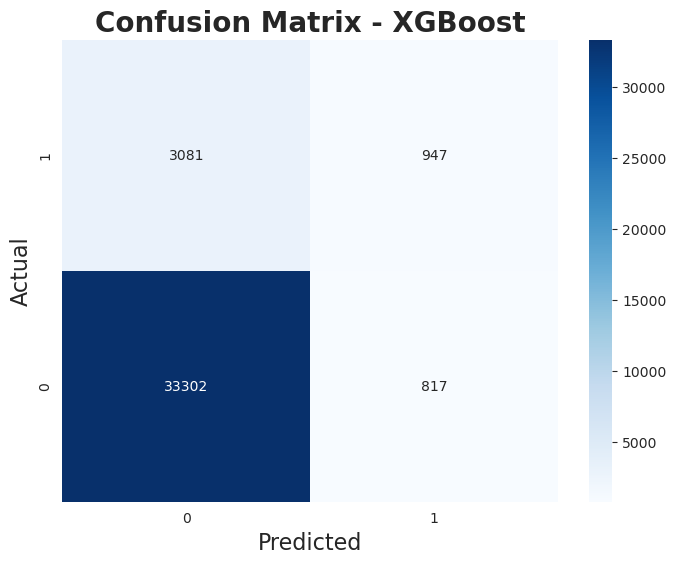

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.98      0.94     34119
        True       0.54      0.24      0.33      4028

    accuracy                           0.90     38147
   macro avg       0.73      0.61      0.64     38147
weighted avg       0.88      0.90      0.88     38147



In [188]:
choice = input("Do you want to train the XGBoost model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter XGBoost model filename to create or load (e.g., xgb.pkl): ").strip()

model_path = os.path.join("models", model_name)

if choice == 'train':
    
    print("########### Training model ###########")

    # Define the parameter grid for XGBoost
    param_grid_xgb = {
        # Number of boosting rounds (trees). More trees can improve performance but increase training time and risk overfitting.
        'n_estimators': [700],
        # 'n_estimators': [100, 200, 300, 500, 700], best : 700

        # Step size shrinkage used in update to prevent overfitting. Lower values require more trees but can improve generalization.
        'learning_rate': [0.5],
        # 'learning_rate': [0.1, 0.2, 0.5], best : 0.5

        # Maximum depth of each tree. Controls model complexity. Deeper trees capture more interactions but may overfit.
        'max_depth': [8]
        # 'max_depth': [4, 6, 8, 10, 15], best : 8
    }

    # Initialize the classifier
    xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

    # Initialize GridSearchCV for XGBoost
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=3, scoring='f1_macro')

    # Perform grid search for XGBoost
    grid_search_xgb.fit(X_train, y_train)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(grid_search_xgb.best_estimator_, model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
    print(f"Best score for XGBoost: {grid_search_xgb.best_score_}")

    # Evaluate the best XGBoost model on the validation set
    best_xgb = grid_search_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_val)

    performance_display(y_val, y_pred_xgb, "XGBoost")

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_xgb = model.predict(X_test)
        performance_display(y_val, y_pred_xgb, "Loaded XGBoost Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

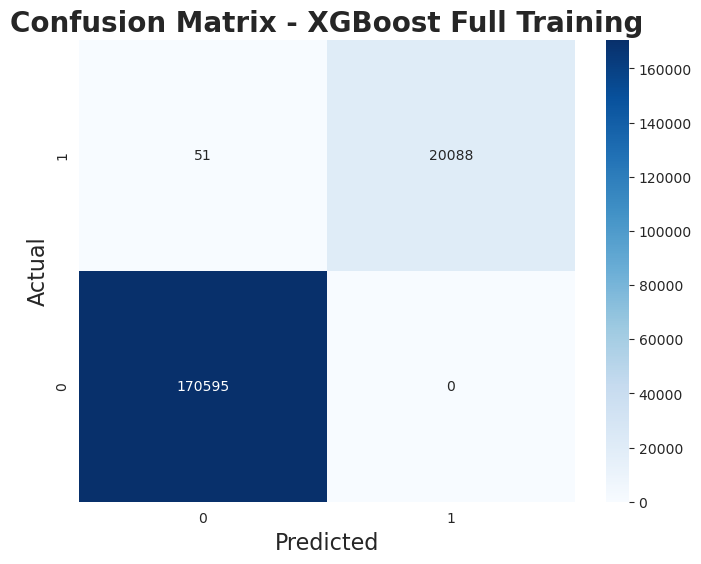

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    170595
        True       1.00      1.00      1.00     20139

    accuracy                           1.00    190734
   macro avg       1.00      1.00      1.00    190734
weighted avg       1.00      1.00      1.00    190734



In [197]:
# train model on full training dataset
xgb = XGBClassifier(n_estimators=500, learning_rate=0.5, max_depth=8, eval_metric='mlogloss', random_state=42)
xgb.fit(X_final, y_final)
joblib.dump(xgb, "models/xgb.pkl")
performance_display(y_final, xgb.predict(X_final), "XGBoost Full Training")

In [198]:
create_submission_file(X_test_final, filename="xgb_V2_submission", model_name="xgb.pkl")

Model loaded from models/xgb.pkl
Submission file saved as submissions/xgb_V2_submission.csv


## 4 - Class imbalance handling

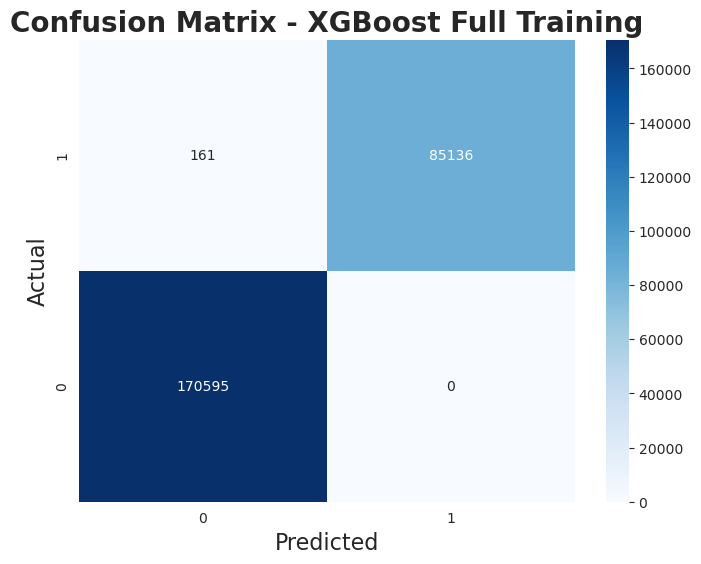

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    170595
        True       1.00      1.00      1.00     85297

    accuracy                           1.00    255892
   macro avg       1.00      1.00      1.00    255892
weighted avg       1.00      1.00      1.00    255892



In [200]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_final, y_final)

# train model on full training dataset
xgb = XGBClassifier(n_estimators=500, learning_rate=0.5, max_depth=8, eval_metric='mlogloss', random_state=42)
xgb.fit(X_resampled, y_resampled)
joblib.dump(xgb, "models/xgb_resampled.pkl")
performance_display(y_resampled, xgb.predict(X_resampled), "XGBoost Full Training")

In [201]:
create_submission_file(X_test_final, filename="xgb_resampled_submission", model_name="xgb_resampled.pkl")

Model loaded from models/xgb_resampled.pkl
Submission file saved as submissions/xgb_resampled_submission.csv


/tmp/ipykernel_45481/3545263906.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


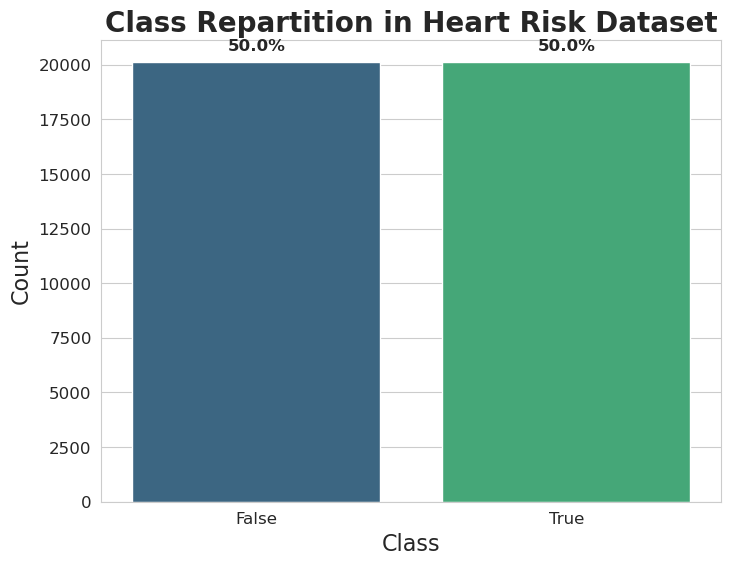

target
False    20139
True     20139
Name: count, dtype: int64


In [203]:
from sklearn.utils import resample

# Step 1: Separate classes
X_true = X_final[y_final.squeeze() == True]
X_false = X_final[y_final.squeeze() == False]

y_true = y_final[y_final.squeeze() == True]
y_false = y_final[y_final.squeeze() == False]

# Step 2: Undersample False class to match True class size
X_false_downsampled, y_false_downsampled = resample(
    X_false,
    y_false,
    replace=False,
    n_samples=len(X_true),
    random_state=42
)

# Step 3: Combine balanced dataset
X_balanced = pd.concat([X_true, X_false_downsampled])
y_balanced = pd.concat([y_true, y_false_downsampled])

# Step 4: Shuffle (optional but recommended)
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Step 5: Confirm result
class_distribution(y_balanced)

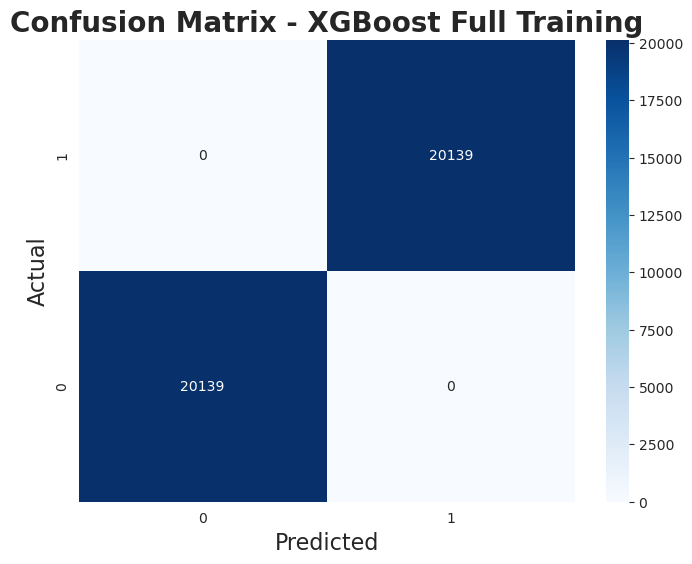

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20139
        True       1.00      1.00      1.00     20139

    accuracy                           1.00     40278
   macro avg       1.00      1.00      1.00     40278
weighted avg       1.00      1.00      1.00     40278



In [204]:
# train model on full training dataset
xgb = XGBClassifier(n_estimators=500, learning_rate=0.5, max_depth=8, eval_metric='mlogloss', random_state=42)
xgb.fit(X_balanced, y_balanced)
joblib.dump(xgb, "models/xgb_balanced.pkl")
performance_display(y_balanced, xgb.predict(X_balanced), "XGBoost Full Training")

In [205]:
create_submission_file(X_test_final, filename="xgb_balanced_submission", model_name="xgb_balanced.pkl")

Model loaded from models/xgb_balanced.pkl
Submission file saved as submissions/xgb_balanced_submission.csv
